In [1]:
import copy
import time, importlib
import h5py
import pylab as pl, numpy as np, glob, pdb
from numpy import log10 as log
from astropy import units as un, constants as cons
from astropy.cosmology import Planck15 as cosmo
import os
import pandas as pd
import scipy, scipy.ndimage
import tqdm
import unyt

In [2]:
import kalepy as kale

In [3]:
import matplotlib.gridspec as gridspec

In [4]:
import palettable

In [5]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.worldline_set as worldline_set
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

In [6]:
import linefinder.utils.file_management_new as file_management
import linefinder.config as config

In [92]:
import galaxy_dive.plot_data.plotting as plotting

In [7]:
import coolingFunction

In [8]:
import trove
import verdict

In [9]:
%matplotlib inline

# Parameters

In [10]:
pm = dict(
    snum = 600,
    ahf_index = 600,
    
    # Data locations
    tables_dir = '/work2/03057/zhafen/stampede2/CoolingTables/',

    # Constants
    mu = 0.62,
    X = 0.7,
    gamma = 5/3,
    
    # Time analysis parameters
    # If we want to ensure some minimum number of snapshots in the galaxy after accreting
    # (remember to account for the last 10 snapshots with small dt)
    minInd = 30,
    # t_1e5 bins in Gyr
    t1e5_width = 0.1,
)

In [11]:
pm = trove.link_params_to_config(
    '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
    variation = 'm12i_md',
    **pm
)

In [12]:
snum = pm['snum']

In [13]:
sim_name = pm['variation']

In [14]:
print( sim_name )

m12i_md


# Load Data

In [15]:
fm = file_management.FileManager( 'hot_halo_physics' )

In [16]:
w = a_worldlines.Worldlines(
    tag = pm['tag'],
    data_dir = pm['data_dir'],
    halo_data_dir = pm['halo_data_dir'],
    ahf_index = pm['ahf_index'],
)

In [17]:
print( w.tag )

hothaloacc


In [18]:
ind = pm['ahf_index'] - snum

# Analyze

## Find $t_{10^5 K}$

In [19]:
# Identify indices where temperature is first above 1e5 K
# This method is equivalent to Jonathan's commented out method above, but without needing to manually handle edge cases,
# at the cost of being slightly slower

# logT = log( w.get_data( 'T' ) )
# inds = []
# for logT_arr in tqdm.tqdm( logT ):

#     ind_ = 0
#     for i in range( logT_arr.size ):
#         if logT_arr[i] > 5.:
#             ind_ = i
#             break

#     inds.append( ind_ )

inds = w.get_data( 't_1e5_inds' )

100%|██████████| 45846/45846 [00:03<00:00, 12311.76it/s]


(-50.0, 100.0)

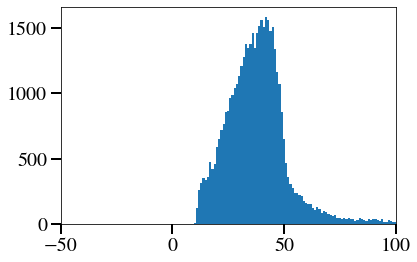

In [20]:
pl.hist(inds,bins=np.arange(-30.5,601))
pl.xlim(-50,100)

In [21]:
# Get t_1e5K
age = w.get_data( 'time' )
t1e5 = age[inds]

(12.804038047790527, 13.804038047790527)

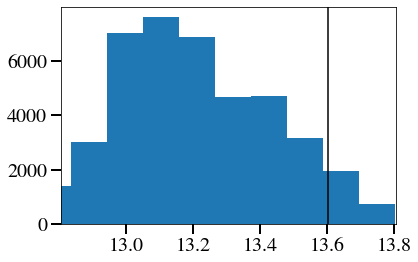

In [22]:
fig = plt.Figure()
ax = plt.gca()

ax.hist(t1e5,bins=128)
ax.axvline( np.nanpercentile( t1e5, 5 ), color='k' )
ax.axvline( np.nanpercentile( t1e5, 100. - 5), color='k' )

ax.set_xlim(age[0] - 1,t1e5.max())


## Get Angular Momentum

In [23]:
jmag_raw = w.get_data( 'Lmag' ) / w.get_data('M') * ( unyt.kpc * unyt.km / unyt.s )

In [24]:
tot_momentum_fp = os.path.join( pm['processed_data_dir'], 'tot_momentums.hdf5' )
tot_mom = verdict.Dict.from_hdf5( tot_momentum_fp )[pm['variation']]['snum{:03d}'.format( snum )]
tot_mom_normed = tot_mom / np.linalg.norm( tot_mom )

In [25]:
j_raw = w.get_data( 'L' ) / w.get_data('M') * ( unyt.kpc * unyt.km / unyt.s )

In [26]:
jz_raw = np.array([ np.dot( j_raw[:,:,i].transpose(), tot_mom_normed ) for i in range( w.snums.size ) ]).transpose()

In [27]:
vc_fp = os.path.join( pm['data_dir'], 'vc_of_tracked_particles.hdf5' )
if os.path.exists( vc_fp ):
    vc_data = verdict.Dict.from_hdf5( vc_fp )
    vc_raw = vc_data[pm['variation']] * unyt.km / unyt.s
else:
    # This can take a while because we need to open all the different profiles (one per snapshot).
    vc_raw = []
    for snum in tqdm.tqdm( w.snums ):
        # The profile data for snapshot 0 is often not saved
        if snum == 0:
            vc_raw.append( np.full( rs.shape, np.nan ) )
            continue
        rs = w.get_data( 'R' )[:,w.snums[0]-snum]
        try:
            vc_i = w.halo_data.get_profile_data( 'vcirc', snum, rs )
        except ( KeyError, TypeError, IndexError ) as e:
            vc_i = np.full( rs.shape, np.nan )
        vc_raw.append( vc_i )
    vc_raw = np.array( vc_raw ).transpose() * unyt.km / unyt.s
    
    vc_data = verdict.Dict({
        pm['variation']: vc_raw.value,
    })
    vc_data.to_hdf5( vc_fp )

In [28]:
rvc_raw = np.array( vc_raw * w.get_data( 'R' ) * unyt.kpc )

## Center on $t_{10^5 K}$

In [29]:
def roll_by_inds(arr, inds):
    rows, cols = np.ogrid[:arr.shape[0],:arr.shape[1]]
    cols = (cols + inds[:,np.newaxis])%arr.shape[1]
    return arr[rows,cols]

In [30]:
minInd = pm['minInd']

In [31]:
# We'll make a dictionary for rolled data
rolled = {}
keys_to_roll = [
    ( 'Den', unyt.cm**-3 ),
    ( 'T', unyt.K ),
    ( 'Z', unyt.Zsun ),
    ( 'M', unyt.Msun ),
    ( 'R', unyt.kpc ),
    ( 'Rz', unyt.kpc ),
    ( 'PType', 1 ),
    ( 't_t_1e5', unyt.Gyr ),
]
for i, ( key, unit ) in enumerate( keys_to_roll ):
    print( key )
    rolled[key] = roll_by_inds( w.get_data( key ), inds )[inds>minInd] * unit

Den
T
Z
M
R
Rz
PType
t_t_1e5


In [32]:
t_unrolled = w.get_selected_data( 'time', tile_data=True )
t = roll_by_inds( t_unrolled, inds )[inds>minInd]

In [33]:
jmag = roll_by_inds( jmag_raw, inds )[inds>minInd]
rvc = roll_by_inds( rvc_raw, inds )[inds>minInd]
vc = roll_by_inds( vc_raw, inds )[inds>minInd]
jz = roll_by_inds( jz_raw, inds )[inds>minInd] * unyt.kpc * unyt.km / unyt.s
t1e5 = t1e5[inds>minInd]

In [34]:
j_rolled = np.array([ roll_by_inds( _, inds )[inds>minInd] for _ in j_raw ])

In [35]:
p_rolled = np.array([ roll_by_inds( _, inds )[inds>minInd] for _ in w.get_data( 'P' ) * unyt.kpc ])

In [36]:
r_gal = np.full( w.n_snaps, np.nan )
r_gal[:w.r_gal.size] = w.r_gal
r_rgal = w.get_data( 'R' ) / r_gal
r_rgal_rolled = roll_by_inds( r_rgal, inds )[inds>minInd]

In [37]:
v_rolled = np.array([ roll_by_inds( _, inds )[inds>minInd] for _ in w.get_data( 'V' ) * unyt.km / unyt.s ])

In [38]:
dt0 = ( np.median( np.gradient( t_unrolled, axis=1)[0,:100 ] ) * unyt.Gyr ).to( 'Myr' )
dnHdt_unrolled = np.gradient( w.get_data( 'Den' )*unyt.cm**-3, axis=1 ) / dt0
dnHdt = roll_by_inds( dnHdt_unrolled[:,:], inds )[inds>minInd]

## Calculate Cooling and Compression

In [39]:
mu, X, gamma = pm['mu'], pm['X'], pm['gamma']

In [40]:
nH = rolled['Den']
T = rolled['T']
r = rolled['R']
K = ( T/nH**(2/3.) * unyt.kb ).to('keV*cm**2')
P = ( (mu * X)**-1 * nH * unyt.kb ).to( 'erg/K/cm**3' )* T
rho = nH * unyt.mp / X

In [41]:
LAMBDA = coolingFunction.LambdaFunc(0, pm['tables_dir'], 0.2485)(
    rolled['T'].value,
    rolled['Den'].value,
    rolled['Z'].value,
) * unyt.erg * unyt.cm**3 / unyt.s #using z=0 is an approximation
rad_per_unit_volume = nH**2*LAMBDA 
rad_per_unit_mass = ( rad_per_unit_volume / rho ).to( 'erg/s/g' )
rad = rad_per_unit_mass * rolled['M']

In [42]:
compress_per_unit_volume = ( P*dnHdt / nH ).to( 'erg/s/cm**3' )
compress_per_unit_mass = ( compress_per_unit_volume  / rho ).to( 'erg/s/g' )

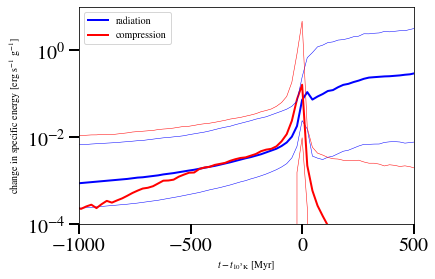

In [43]:
inds2 = np.arange(-50,100)
pl.figure()
ax=pl.subplot(111)
for ip,p in enumerate((16,50,84)):
    pl.plot(inds2*dt0, np.nanpercentile(rad_per_unit_mass,p,axis=0)[inds2],
            c='b',lw=(0.5,2)[ip==1],label=('_',r'radiation')[ip==1])
    pl.plot(inds2*dt0, np.nanpercentile(compress_per_unit_mass,p,axis=0)[inds2],
            c='r',lw=(0.5,2)[ip==1],
           label=('_',r'compression')[ip==1])
ax.set_yscale('log')
pl.xlim(-1000,500)
pl.ylim(1e-4,10) 
pl.ylabel(r'change in specific energy [${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$]')
pl.xlabel(r'$t - t_{10^5{\rm K}}\ [{\rm Myr}]$')
pl.legend()
# pl.savefig(figDir+'rad_vs_compress.png')

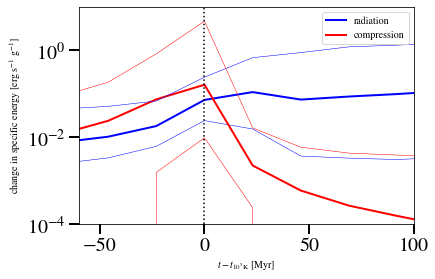

In [44]:
inds2 = np.arange(-50,100)
pl.figure()
ax=pl.subplot(111)
for ip,p in enumerate((16,50,84)):
    pl.plot(inds2*dt0, np.nanpercentile(rad_per_unit_mass,p,axis=0)[inds2],
            c='b',lw=(0.5,2)[ip==1],label=('_',r'radiation')[ip==1])
    pl.plot(inds2*dt0, np.nanpercentile(compress_per_unit_mass,p,axis=0)[inds2],
            c='r',lw=(0.5,2)[ip==1],
           label=('_',r'compression')[ip==1])
ax.set_yscale('log')
pl.xlim(-60,100)
pl.ylim(1e-4,10) 
pl.ylabel(r'change in specific energy [${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$]')
pl.xlabel(r'$t - t_{10^5{\rm K}}\ [{\rm Myr}]$')
pl.legend()
pl.axvline(0,c='k',ls=':')
# pl.savefig(figDir+'rad_vs_compress_zoom.png')

## Calculate Gas Temperature and Density
Need to do this separately because we don't want stars messing up the temp

In [45]:
med_gas_temp = []
low_gas_temp = []
high_gas_temp = []
for i in tqdm.tqdm( inds2 ):
    gas_temp = rolled['T'][:,i][rolled['PType'][:,i]==0]
    med_gas_temp.append( np.nanmedian( gas_temp ) )
    low_gas_temp.append( np.nanpercentile( gas_temp, 16. ) )
    high_gas_temp.append( np.nanpercentile( gas_temp, 84. ) )
med_gas_temp = np.array( med_gas_temp )
low_gas_temp = np.array( low_gas_temp )
high_gas_temp = np.array( high_gas_temp )

100%|██████████| 150/150 [00:00<00:00, 504.77it/s]


In [46]:
med_gas_den = []
low_gas_den = []
high_gas_den = []
for i in tqdm.tqdm( inds2 ):
    gas_den = rolled['Den'][:,i][rolled['PType'][:,i]==0]
    med_gas_den.append( np.nanmedian( gas_den ) )
    low_gas_den.append( np.nanpercentile( gas_den, 16. ) )
    high_gas_den.append( np.nanpercentile( gas_den, 84. ) )
med_gas_den = np.array( med_gas_den )
low_gas_den = np.array( low_gas_den )
high_gas_den = np.array( high_gas_den )

100%|██████████| 150/150 [00:00<00:00, 509.63it/s]


## Bin into bins of $t_{10^5 K}$ with fixed width and sum heating and cooling

In [47]:
# Bins. Note that we offset by the width of the last snapshot to avoid the most obvious edge cases
t1e5_bins = np.arange( age.max() + 0.5*(age[0] - age[1]), 11., -pm['t1e5_width'] )

In [48]:
time = inds2*dt0

In [49]:
# This is essential. If not removing outliers we get very weird results when calculating the mean.
def remove_outliers( a, q=99 ):
    outlier = np.nanpercentile( np.abs( a ), q )
    result = copy.copy( a )
    result[np.abs(a)>outlier] = outlier
    
    return result

In [50]:
binned_rad_per_unit_mass = []
binned_compress_per_unit_mass = []
mean_j = []
mean_rad_per_unit_mass = []
mean_compress_per_unit_mass = []
for i, start in enumerate( t1e5_bins[:-1] ):
    
    end = t1e5_bins[i+1]
    in_bin = ( t1e5 < start ) & ( t1e5 > end )
    
    binned_rad_per_unit_mass.append( rad_per_unit_mass[in_bin] )
    binned_compress_per_unit_mass.append( compress_per_unit_mass[in_bin] )
    
    # Don't try to sum t1e5 bins with too few particles
    if in_bin.sum() < t1e5.size * 0.05:
        mean_rad_per_unit_mass.append( np.full( (600,), np.nan ) )
        mean_compress_per_unit_mass.append( np.full( (600,), np.nan ) )
        mean_j.append( np.full( (3, 600,), np.nan ) )
        continue
        
    # Avoid edge cases affecting the results
    rad = remove_outliers( rad_per_unit_mass[in_bin] )
    compress = remove_outliers( compress_per_unit_mass[in_bin] )
    
    mean_j_i =  np.array([ np.nanmean( _[in_bin], axis=0 ) for _ in j_rolled ])
        
    mean_rad_per_unit_mass.append( np.nanmean( rad, axis=0 ) )
    mean_compress_per_unit_mass.append( np.nanmean( compress, axis=0 ) )
    mean_j.append( mean_j_i )

## Vector Quantity Manipulation

In [51]:
mean_jz = np.array([ np.dot( _.transpose(), tot_mom_normed ) for _ in mean_j ])
mean_jmag = np.array([ np.linalg.norm( _, axis=0 ) for _ in mean_j ])
mean_jz_jmag = mean_jz / mean_jmag

In [52]:
mean_j_all = np.array([ np.nanmean( _, axis=0 ) for _ in j_rolled ])
mean_jz_all = np.dot( mean_j_all.transpose(), tot_mom_normed )

In [53]:
total_j = np.array([ np.nansum( _, axis=0 ) for _ in j_rolled ])
total_jz = np.dot( total_j.transpose(), tot_mom_normed )
total_jmag = np.linalg.norm( total_j, axis=0 )
total_jz_jmag = total_jz / total_jmag
circulation = total_jmag / np.nansum( jmag, axis=0 )

In [54]:
n_bin = np.array([ _.shape[0] for _ in binned_rad_per_unit_mass ])

In [55]:
vz = np.array([ np.dot( _, tot_mom_normed ) for _ in v_rolled.transpose() ]).transpose()
z = np.array([ np.dot( _, tot_mom_normed ) for _ in p_rolled.transpose() ]).transpose()

In [56]:
vr = []
vz = []
vphi = []
jr = []
jz = []
jphi = []
v_rolled_t = v_rolled.transpose()
j_rolled_t = j_rolled.transpose()
for i, p_snum in tqdm.tqdm( enumerate( p_rolled.transpose(), ) ):
    
    # Radial
    norms = np.linalg.norm( p_snum, axis=1 )
    r_hat = ( p_snum / norms[:,np.newaxis] )
    vr_snum = ( r_hat * v_rolled_t[i] ).sum( axis=1 )
    jr_snum = ( r_hat * j_rolled_t[i] ).sum( axis=1 )
    vr.append( vr_snum )
    jr.append( jr_snum )
    
    # Vertical
    vz_snum = np.dot( v_rolled_t[i], tot_mom_normed )
    jz_snum = np.dot( j_rolled_t[i], tot_mom_normed )
    vz.append( vz_snum )
    jz.append( jz_snum )
    
    # Tangential
    vr_term = vr_snum[:,np.newaxis] * r_hat
    vz_term = ( vz_snum * tot_mom_normed[:,np.newaxis] ).transpose()
    vphi_snum_vec = v_rolled_t[i] - vr_term - vz_term
    vphi_snum = np.linalg.norm( vphi_snum_vec, axis=1 )
    jr_term = jr_snum[:,np.newaxis] * r_hat
    jz_term = ( jz_snum * tot_mom_normed[:,np.newaxis] ).transpose()
    jphi_snum_vec = j_rolled_t[i] - jr_term - jz_term
    jphi_snum = np.linalg.norm( jphi_snum_vec, axis=1 )
    vphi.append( vphi_snum )
    jphi.append( jphi_snum )
    
vr = np.array( vr ).transpose()
vz = np.array( vz ).transpose()
vphi = np.array( vphi ).transpose()
jr = np.array( jr ).transpose()
jz = np.array( jz ).transpose()
jphi = np.array( jphi ).transpose()

601it [00:03, 153.72it/s]


## Volume Filling Factor

In [57]:
vol = rolled['M'].to( 'Msun' ) / ( rolled['Den'] * unyt.mp ).to( 'Msun/kpc**3' )

In [58]:
r_centers = []
r_hists = []
vol_fill = []
for i in tqdm.tqdm( range( r.shape[1] ) ):

    # Bin in r
    r_sl = r[:,i]
    r_bins = np.linspace( np.nanmin( r_sl ), np.nanmax( r_sl ), 16 )
    hist, _ = np.histogram(
        r[:,i],
        r_bins,
    )
    r_centers.append( r_bins[:-1] + 0.5 * (r_bins[1] - r_bins[0] ) )
    r_hists.append( hist )

    # Compute volume-filling-fraction at each radius
    vol_sl = []
    vol_max = []
    for j, r_in in enumerate( r_bins[:-1] ):
        r_out = r_bins[j+1]
        in_bin = ( r_in < r_sl ) & ( r_sl < r_out )
        vol_sl.append( vol[:,i][in_bin].sum() )
        vol_max.append( 4./3.*np.pi * ( r_out**3. - r_in**3. ) )
    vol_sl = np.array( vol_sl )
    vol_max = np.array( vol_max )
    vol_fill.append( vol_sl / vol_max )

100%|██████████| 601/601 [00:06<00:00, 98.66it/s] 


In [59]:
r_centers = np.array( r_centers )
r_hists = np.array( r_hists )
vol_fill = np.array( vol_fill )

In [60]:
normed_fraction = r_hists / np.nanmax( r_hists, axis=1 )[:,np.newaxis]

In [61]:
# Setup time bins
t_centers = w.get_data( 'time' )
t_bins = np.full( t_centers.size+1, 0. )
t_bins[:-1] = t_centers - 0.001

In [62]:
# Setup r bins
r_bins = np.linspace( 0., 50., 64 )

In [63]:
# Create volume weights
vol = w.get_data( 'M' ) * unyt.Msun / ( w.get_data( 'Den' ) * unyt.mp / unyt.cm**3 ).to( 'Msun/kpc**3' )
vol[np.isnan(vol)] = 0.

In [64]:
vol_in_shell = []
for i in tqdm.tqdm( range( vol.shape[1] ) ):

    # Bin in r
    hist, _ = np.histogram(
        w.get_data( 'R' )[:,i],
        r_bins,
        weights = vol[:,i],
        density = False,
    )
    vol_in_shell.append( hist )
vol_in_shell = np.array( vol_in_shell )

100%|██████████| 601/601 [00:02<00:00, 231.33it/s]


In [65]:
vol_shell = 4./3.*np.pi * np.array([ r_bins[1:]**3. - r_bins[:-1]**3. ])

In [66]:
vol_fill = vol_in_shell / vol_shell

(12.560444831848145, 13.560444831848145)

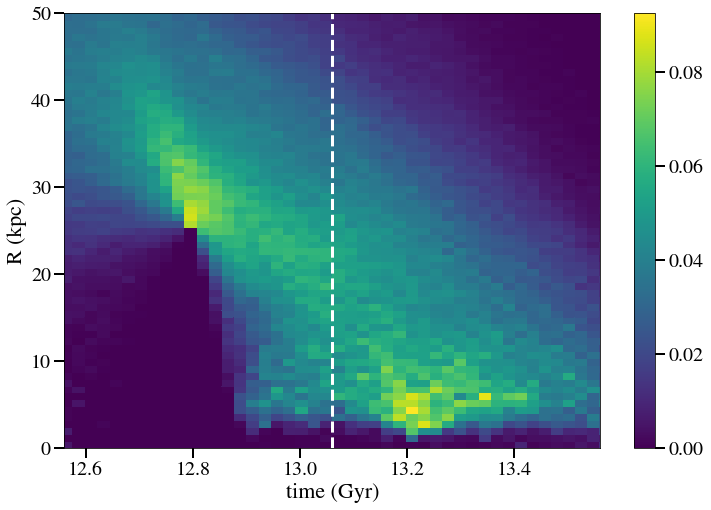

In [67]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

mesh = ax.pcolormesh(
    t_bins,
    r_bins,
    vol_fill.transpose(),
)
cbar = plt.colorbar( mesh )

t1e5_med = np.median( t1e5 )
ax.axvline(
    t1e5_med,
    color = 'w',
    linewidth = 3,
    linestyle = '--',
)

ax.set_xlabel( 'time (Gyr)', fontsize=22 )
ax.set_ylabel( 'R (kpc)', fontsize=22 )
ax.set_xlim( t1e5_med - 0.5, t1e5_med + 0.5 )

Text(0.5, 0, '$t - t_{10^5{\\rm K}}\\ [{\\rm Myr}]$')

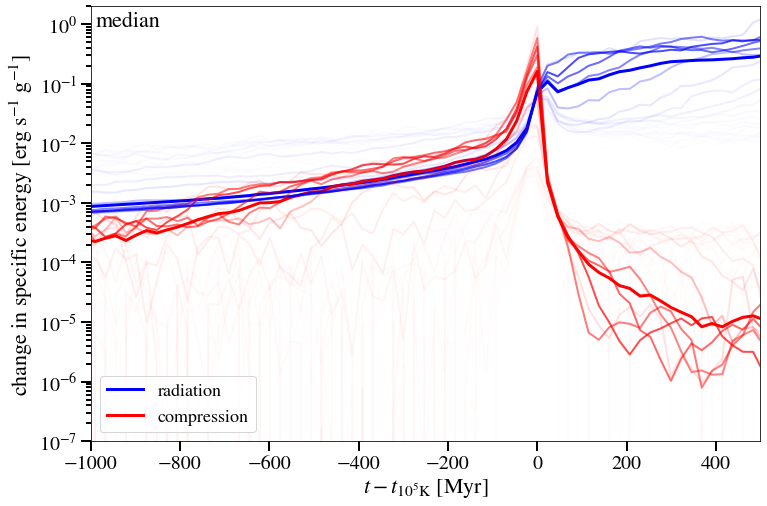

In [68]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

# Total median
ax.plot(
    time,
    np.nanmedian( rad_per_unit_mass, axis=0 )[inds2],
    color = 'b',
    linewidth = 3,
    label = 'radiation',
)
ax.plot(
    time,
    np.nanmedian( compress_per_unit_mass, axis=0 )[inds2],
    color = 'r',
    linewidth = 3,
    label = 'compression',
)

# In bins
for i, rad in enumerate( binned_rad_per_unit_mass ):
    ax.plot(
        time,
        np.nanmedian( rad, axis=0 )[inds2],
        color = 'b',
        alpha = n_bin[i]/n_bin.max() * 0.7,
        linewidth = 2,
    )
    ax.plot(
        time,
        np.nanmedian( binned_compress_per_unit_mass[i], axis=0 )[inds2],
        color = 'r',
        alpha = n_bin[i]/n_bin.max() * 0.7,
        linewidth = 2,
    )
    
ax.annotate(
    text ='median',
    xy = ( 0, 1 ),
    xytext = ( 5, -5 ),
    xycoords = 'axes fraction',
    textcoords = 'offset points',
    fontsize = 22,
    va = 'top',
    ha = 'left',
)

ax.set_yscale( 'log' )
ax.set_xlim( -1000, 500 )
ax.set_ylim( 1e-7, 2 )
ax.legend( prop={'size': 18}, loc='lower left', )

ax.set_ylabel( r'change in specific energy [${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$]', fontsize=22 )
ax.set_xlabel( r'$t - t_{10^5{\rm K}}\ [{\rm Myr}]$', fontsize=22 )

# pl.savefig( figDir+'rad_vs_compress_median.pdf' )

## Summary Figure

### Time Offset
We're going to offset the time visually s.t. the median crosses T=1e5 K right at t=0.
The reason it doesn't do that automatically is because of limited time resolution.

In [69]:
# Calculate offset
close_to_t1e5 = np.abs( time ) < 500.
time_offset = scipy.interpolate.interp1d( np.log10( med_gas_temp[close_to_t1e5] ), time[close_to_t1e5] )( 5. ) * unyt.Myr

In [70]:
time -= time_offset

### Internal Version
Has more stuff on it, a bit messy.

In [71]:
colormap = palettable.cartocolors.qualitative.Safe_10.mpl_colors

#### Setup

In [72]:
nrows = 8
fig = plt.figure( figsize=(12, 4 * nrows), facecolor='w' )
# main_ax = plt.gca()

gs = gridspec.GridSpec( ncols=1, nrows=nrows, )

errt = 30./2.

i = 0

<Figure size 864x2304 with 0 Axes>

#### Temperature

In [73]:
ax = fig.add_subplot( gs[i,:] )

ax.annotate(
    text =r'A: hot to cool',
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# Plot T
ax.plot(
    time,
    med_gas_temp,
    color = 'k',
    linewidth = 3,
)
ax.fill_between(
    time,
    low_gas_temp,
    high_gas_temp,
    color = 'k',
    alpha = 0.1,
)

# Label lines
ax.axhline(
    1e5,
    color = '0.1',
    linewidth = 1,
)
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

ax.set_xlim( -500, 500 )
ax.set_ylim( 1e2, 3e6 )
ax.set_ylabel(
    'temperature (K)',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
ax.set_yscale( 'log' )
ax.tick_params( right=True, labelright=True, )
i += 1

#### Radius

In [74]:
ax = fig.add_subplot( gs[i,:] )

ax.annotate(
    text =r'B: inflowing to stalled',
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

r_med = np.nanpercentile( r, 50., axis=0 )
ax.plot(
    time,
    r_med[inds2],
    color = 'k',
    linewidth = 3,
)
ax.fill_between(
    time,
    np.nanpercentile( r, 16, axis=0 )[inds2],
    np.nanpercentile( r, 84., axis=0 )[inds2],
    color = 'k',
    alpha = 0.1,
)

# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)
# ax.axhline(
#     r_med[0],
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
# ax.annotate(
#     text =r'$R(t=t_{10^5{\rm K}})$',
#     xy = ( 0, r_med[0] ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 22,
#     ha = 'left',
#     va = 'bottom',
# )

ax.axhline(
    w.r_gal[0],
    color = 'k',
    linestyle = '--',
)
ax.annotate(
#     text =r'$4 R_\star(z=0)$',
    text =r'$R_{\rm gal}$',
#     text ='disk radius',
    xy = ( 0, w.r_gal[0] ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 22,
    ha = 'left',
    va = 'bottom',
    color = 'k',
    fontweight = 'bold',
)

ax.set_xlim( -500, 500 )
ax.set_ylim( 0, 90 )
# ax.set_yscale( 'log' )
# ax.set_ylim( 5, 100 )
ax.set_ylabel(
    'R (kpc)',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
    
ax_r = ax.twinx()
ax_ylim = ax.get_ylim()
ax_r.set_ylim( np.array( ax_ylim ) / w.r_vir[600] )
ax_r.set_ylabel( r'R/$R_{\rm vir}(z=0)$', fontsize=22 )

# ax.tick_params( right=True, labelright=True, )
i += 1

#### Vertical Height

In [75]:
ax = fig.add_subplot( gs[i,:] )

z_abs = np.abs( z[:,inds2] )

ax.plot(
    time,
    np.nanmedian( z_abs, axis=0 ),
    color = 'k',
    linewidth = 3,
)
ax.fill_between(
    time,
    np.nanpercentile( z_abs, 16, axis=0 ),
    np.nanpercentile( z_abs, 84., axis=0 ),
    color = 'k',
    alpha = 0.1,
)


# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)
# ax.axhline(
#     r_med[0],
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
# ax.annotate(
#     text =r'$R(t=t_{10^5{\rm K}})$',
#     xy = ( 0, r_med[0] ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 22,
#     ha = 'left',
#     va = 'bottom',
# )

ax.axhline(
    w.r_gal[0],
    color = 'k',
    linestyle = '--',
)
ax.annotate(
#     text =r'$4 R_\star(z=0)$',
    text =r'$R_{\rm gal}$',
#     text ='disk radius',
    xy = ( 0, w.r_gal[0] ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 22,
    ha = 'left',
    va = 'bottom',
    color = 'k',
    fontweight = 'bold',
)

ax.set_xlim( -500, 500 )
ax.set_ylim( 0, 1.5 * w.r_gal[0] )
# ax.set_yscale( 'log' )
# ax.set_ylim( 5, 100 )
ax.set_ylabel(
    'z (kpc)',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
    
ax_r = ax.twinx()
ax_ylim = ax.get_ylim()
ax_r.set_ylim( np.array( ax_ylim ) / w.r_vir[600] )
ax_r.set_ylabel( r'z/$R_{\rm vir}(z=0)$', fontsize=22 )

# ax.tick_params( right=True, labelright=True, )
i += 1

#### Angular Momentum Components

In [76]:
ax = fig.add_subplot( gs[i,:] )

ax.annotate(
    text =r'C: unsupported to supported',
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# # Total angular momentum
# j_med = np.nanpercentile( jmag, 50., axis=0 )
# ax.plot(
#     time,
#     j_med[inds2],
# #     color = colormap[3],
#     color = 'k',
#     linewidth = 5,
# )
# ax.fill_between(
#     time,
#     np.nanpercentile( jmag, 16, axis=0 )[inds2],
#     np.nanpercentile( jmag, 84., axis=0 )[inds2],
# #     color = colormap[3],
#     color = 'k',
#     alpha = 0.1,
# )
# y_annot = scipy.interpolate.interp1d( time, j_med[inds2] )( -500 )
# ax.annotate(
#     text =r'$\mid \vec j \mid$',
#     xy = ( 0, y_annot ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 24,
#     ha = 'left',
#     va = 'bottom',
# #     color = colormap[3],
#     color = 'k',
#     fontweight = 'bold',
# )

# Jr
jr_med = np.nanpercentile( jr, 50., axis=0 )
ax.plot(
    time,
    jr_med[inds2],
#     total_jz_jmag[inds2],
    color = colormap[5],
    linewidth = 5,
)
ax.fill_between(
    time,
    np.nanpercentile( jr, 16, axis=0 )[inds2],
    np.nanpercentile( jr, 84., axis=0 )[inds2],
    color = colormap[5],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, jr_med[inds2] )( -500 )
ax.annotate(
    text =r'$j_r$',
    xy = ( -200, y_annot ),
    xycoords = 'data',
    xytext = ( -2, 2 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[5],
    fontweight = 'bold',
)

# Jz
jz_med = np.nanpercentile( jz, 50., axis=0 )
ax.plot(
    time,
    jz_med[inds2],
#     total_jz_jmag[inds2],
    color = colormap[3],
    linewidth = 5,
)
ax.fill_between(
    time,
    np.nanpercentile( jz, 16, axis=0 )[inds2],
    np.nanpercentile( jz, 84., axis=0 )[inds2],
    color = colormap[3],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, jz_med[inds2] )( -500 )
ax.annotate(
    text =r'$j_z$',
    xy = ( -200, y_annot ),
    xycoords = 'data',
    xytext = ( -2, -2 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[3],
    fontweight = 'bold',
)

# Jphi
jphi_med = np.nanpercentile( jphi, 50., axis=0 )
ax.plot(
    time,
    jphi_med[inds2],
#     total_jz_jmag[inds2],
    color = colormap[4],
    linewidth = 5,
)
ax.fill_between(
    time,
    np.nanpercentile( jphi, 16, axis=0 )[inds2],
    np.nanpercentile( jphi, 84., axis=0 )[inds2],
    color = colormap[4],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, jphi_med[inds2] )( -400 )
ax.annotate(
    text =r'$j_\phi$',
    xy = ( -400, y_annot ),
    xycoords = 'data',
    xytext = ( 2, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[4],
    fontweight = 'bold',
)

# RVc
rvc_med = np.nanpercentile( rvc, 50., axis=0 )
ax.plot(
    time,
    rvc_med[inds2],
#     total_jz_jmag[inds2],
    color = '.1',
    linewidth = 2,
    linestyle = '-.',
)
# ax.fill_between(
#     time,
#     np.nanpercentile( rvc, 16, axis=0 )[inds2],
#     np.nanpercentile( rvc, 84., axis=0 )[inds2],
#     color = colormap[2],
#     alpha = 0.1,
# )
y_annot = scipy.interpolate.interp1d( time, rvc_med[inds2] )( -200 )
ax.annotate(
    text =r'$Rv_c(R)$',
    xy = ( -200, y_annot ),
    xycoords = 'data',
    xytext = ( -2, -2 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'right',
    va = 'top',
    color = 'k',
    fontweight = 'bold',
)

ax.axhline(
    1,
    color = '0.1',
    linewidth = 0.5,
)

# Label lines
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

# ax.axhline(
#     j_med[0],
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
# ax.annotate(
#     text =r'$j(t=t_{10^5{\rm K}})$',
#     xy = ( -200, j_med[0] ),
# #     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xycoords = 'data',
#     xytext = ( -5, -5 ),
#     textcoords = 'offset points',
#     fontsize = 22,
#     ha = 'right',
#     va = 'top',
# )

ax.set_xlim( -500, 500 )
ax.set_ylim( -1e3, 7e3 )
# ax.set_ylim( 0, 1. )
ax.set_ylabel(
    'specific\nangular momentum\n(kpc km/s)',
#     r'$\mid \vec j \mid / (\, Rv_c(R)\, )$',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
ax.tick_params( right=True, labelright=True, )
i += 1

#### Circularity

In [77]:

ax = fig.add_subplot( gs[i,:] )

# y_annot = scipy.interpolate.interp1d( time, np.nanpercentile( c, 84., axis=0 )[inds2] )( -100 )
ax.annotate(
    text =r'D: decoherent to coherent',
    xy = ( 0, 0 ),
    xycoords = 'axes fraction',
    xytext = ( 10, 10 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'left',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# # Jr
# cr = jr / jmag
# cr_med = np.nanpercentile( cr, 50., axis=0 )
# ax.plot(
#     time,
#     jr_med[inds2],
# #     total_jz_jmag[inds2],
#     color = colormap[5],
#     linewidth = 5,
# )
# ax.fill_between(
#     time,
#     np.nanpercentile( cr, 16, axis=0 )[inds2],
#     np.nanpercentile( cr, 84., axis=0 )[inds2],
#     color = colormap[5],
#     alpha = 0.1,
# )
# y_annot = scipy.interpolate.interp1d( time, cr_med[inds2] )( -500 )
# ax.annotate(
#     text =r'$j_r$ / $\mid \vec j \mid$',
#     xy = ( -200, y_annot ),
#     xycoords = 'data',
#     xytext = ( -2, 2 ),
#     textcoords = 'offset points',
#     fontsize = 24,
#     ha = 'left',
#     va = 'bottom',
#     color = colormap[5],
#     fontweight = 'bold',
# )

# Jz
cz = jz / jmag
cz_med = np.nanpercentile( cz, 50., axis=0 )
ax.plot(
    time,
    cz_med[inds2],
#     total_jz_jmag[inds2],
    color = colormap[3],
    linewidth = 5,
)
ax.fill_between(
    time,
    np.nanpercentile( cz, 16, axis=0 )[inds2],
    np.nanpercentile( cz, 84., axis=0 )[inds2],
    color = colormap[3],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, cz_med[inds2] )( errt )
ax.annotate(
    text =r'$j_z$ / $\mid \vec j \mid$',
    xy = ( errt, y_annot ),
    xycoords = 'data',
    xytext = ( 2, -2 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'top',
    color = colormap[3],
    fontweight = 'bold',
)

# Jphi
cphi = jphi / jmag
cphi_med = np.nanpercentile( cphi, 50., axis=0 )
ax.plot(
    time,
    cphi_med[inds2],
#     total_jz_jmag[inds2],
    color = colormap[4],
    linewidth = 5,
)
ax.fill_between(
    time,
    np.nanpercentile( cphi, 16, axis=0 )[inds2],
    np.nanpercentile( cphi, 84., axis=0 )[inds2],
    color = colormap[4],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, cphi_med[inds2] )( -200 )
ax.annotate(
    text =r'$j_\phi$ / $\mid \vec j \mid$',
    xy = ( -200, y_annot ),
    xycoords = 'data',
    xytext = ( -2, -2 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'right',
    va = 'top',
    color = colormap[4],
    fontweight = 'bold',
)

ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

# # Net jz/j in bins
# for i, jz_jmag in enumerate( mean_jz_jmag ):
#     ax.plot(
#         time,
#         jz_jmag[inds2],
#         color = 'k',
#         alpha = n_bin[i]/n_bin.max(),
#         linewidth = 2,
#         linestyle = '--',
#     )

# Net jz/j
ax.plot(
    time,
    total_jz_jmag[inds2],
    color = 'k',
    linestyle = '--',
    linewidth = 2,
)
# y_annot = scipy.interpolate.interp1d( time, total_jz_jmag[inds2] )( -500 )
# ax.annotate(
#     text =r'$L_z$ / $\mid \vec L \mid$',
#     xy = ( 0, y_annot ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, -2.5 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'left',
#     fontsize = 22,
# )

# # Circulation
# ax.plot(
#     time,
#     circulation[inds2],
#     color = 'k',
#     linestyle = '-.',
#     linewidth = 2,
# )

ax.axhline(
    1,
    color = '0.1',
    linewidth = 0.5,
)
ax.annotate(
    text ='co-rotating',
    xy = ( 1, 1 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
)
ax.axhline(
    0,
    color = '0.1',
    linewidth = 0.5,
)
ax.annotate(
    text ='perpendicular',
    xy = ( 1, 0 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, -5 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
)
ax.annotate(
    text ='counter-rotating',
    xy = ( 1, -1 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, 5 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'right',
    fontsize = 22,
)

ax.set_xlim( -500, 500 )
ax.set_ylim( -1, 1 )
ax.set_ylabel(
    r'$j_z$ / $\mid \vec j \mid$',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
ax.tick_params( right=True, labelright=True, )
i += 1


#### Velocity Components

In [78]:
ax = fig.add_subplot( gs[i,:] )

# y_annot = scipy.interpolate.interp1d( time, np.nanpercentile( c, 84., axis=0 )[inds2] )( -100 )
# ax.annotate(
#     text =r'D: decoherent to coherent',
#     xy = ( 0, 0 ),
#     xycoords = 'axes fraction',
#     xytext = ( 10, 10 ),
#     textcoords = 'offset points',
#     va = 'bottom',
#     ha = 'left',
#     fontsize = 22,
#     bbox = dict(boxstyle='round', facecolor='w')
# )

# Vr
vr_med = np.nanpercentile( vr, 50., axis=0 )
ax.plot(
    time,
    vr_med[inds2],
#     total_jz_jmag[inds2],
    color = colormap[5],
    linewidth = 5,
)
ax.fill_between(
    time,
    np.nanpercentile( vr, 16, axis=0 )[inds2],
    np.nanpercentile( vr, 84., axis=0 )[inds2],
    color = colormap[5],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, vr_med[inds2] )( -500 )
ax.annotate(
    text =r'$v_r$',
    xy = ( -200, y_annot ),
    xycoords = 'data',
    xytext = ( -2, -2 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[5],
    fontweight = 'bold',
)

# Vz
vz_med = np.nanpercentile( vz, 50., axis=0 )
ax.plot(
    time,
    vz_med[inds2],
#     total_jz_jmag[inds2],
    color = colormap[3],
    linewidth = 5,
)
ax.fill_between(
    time,
    np.nanpercentile( vz, 16, axis=0 )[inds2],
    np.nanpercentile( vz, 84., axis=0 )[inds2],
    color = colormap[3],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, vz_med[inds2] )( -500 )
ax.annotate(
    text =r'$v_z$',
    xy = ( -200, y_annot ),
    xycoords = 'data',
    xytext = ( -2, -2 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[3],
    fontweight = 'bold',
)

# Vphi
vphi_med = np.nanpercentile( vphi, 50., axis=0 )
ax.plot(
    time,
    vphi_med[inds2],
#     total_jz_jmag[inds2],
    color = colormap[4],
    linewidth = 5,
)
ax.fill_between(
    time,
    np.nanpercentile( vphi, 16, axis=0 )[inds2],
    np.nanpercentile( vphi, 84., axis=0 )[inds2],
    color = colormap[4],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, vphi_med[inds2] )( -500 )
ax.annotate(
    text =r'$v_\phi$',
    xy = ( -200, y_annot ),
    xycoords = 'data',
    xytext = ( 2, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[4],
    fontweight = 'bold',
)

# Vc
vc_med = np.nanpercentile( vc, 50., axis=0 )
ax.plot(
    time,
    vc_med[inds2],
#     total_jz_jmag[inds2],
    color = '.1',
    linewidth = 2,
    linestyle = '-.',
)
# ax.fill_between(
#     time,
#     np.nanpercentile( vc, 16, axis=0 )[inds2],
#     np.nanpercentile( vc, 84., axis=0 )[inds2],
#     color = colormap[2],
#     alpha = 0.1,
# )
y_annot = scipy.interpolate.interp1d( time, vc_med[inds2] )( -500 )
ax.annotate(
    text =r'$v_c(R)$',
    xy = ( -200, y_annot ),
    xycoords = 'data',
    xytext = ( 2, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = 'k',
    fontweight = 'bold',
)

ax.axhline(
    1,
    color = '0.1',
    linewidth = 0.5,
)

# Label lines
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

ax.set_xlim( -500, 500 )
ax.set_ylim( -200, 300 )
ax.set_ylabel(
    'velocity (km/s)',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
# ax.set_yscale( 'log' )
ax.tick_params( right=True, labelright=True, )
i += 1

#### Energy

In [79]:
ax = fig.add_subplot( gs[i,:] )

ax.annotate(
    text =r'E: balanced to cooled',
    xy = ( 0, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'left',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

for j, rad in enumerate( mean_rad_per_unit_mass ):
    
#     # Don't look at edge cases from early on
#     if t1e5_bins[i] < 12:
#         continue
    
    ax.plot(
        time,
        rad[inds2],
        color = colormap[0],
        alpha = n_bin[j]/n_bin.max(),
        linewidth = 2,
    )
    ax.plot(
        time,
        mean_compress_per_unit_mass[j][inds2],
        color = colormap[1],
        alpha = n_bin[j]/n_bin.max(),
        linewidth = 2,
    )

# ax.plot(
#     time,
#     np.nanmean( rad_per_unit_mass, axis=0 )[inds2],
#     color = 'b',
#     linewidth = 3,
#     linestyle = '--',
# )
# ax.plot(
#     time,
#     np.nanmean( compress_per_unit_mass, axis=0 )[inds2],
#     color = 'r',
#     linewidth = 3,
#     linestyle = '--',
# )
# Total mean
# ax.plot(
#     time,
#     np.nanmean( remove_outliers( rad_per_unit_mass ), axis=0 )[inds2],
#     color = 'b',
#     linewidth = 3,
#     label = 'radiation',
# )
# ax.plot(
#     time,
#     np.nanmean( remove_outliers( compress_per_unit_mass ), axis=0 )[inds2],
#     color = 'r',
#     linewidth = 3,
#     label = 'compression',
# )

ax.annotate(
    text ='radiation cooling',
    xy = ( 1, 1. ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, -5 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    color = colormap[0],
    fontweight = 'bold',
)
ax.annotate(
    text ='compression heating',
    xy = ( 1, 4e-3 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, 5 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'right',
    fontsize = 22,
    color = colormap[1],
    fontweight = 'bold',
)

# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)
    
# ax.annotate(
#     text ='mean',
#     xy = ( 0, 1 ),
#     xytext = ( 5, -5 ),
#     xycoords = 'axes fraction',
#     textcoords = 'offset points',
#     fontsize = 22,
#     va = 'top',
#     ha = 'left',
# )

ax.set_yscale( 'log' )
ax.set_xlim( -500, 500 )
ax.set_ylim( 1e-3, 10**0.5 )
# ax.legend( prop={'size': 18}, loc='lower left', )
ax.tick_params( right=True, labelright=True, )
i += 1

ax.set_ylabel(
    'net change in\nspecific energy\n' + r'(${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$)',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)

Text(0, 0.5, 'net change in\nspecific energy\n(${\\rm erg}\\ {\\rm s}^{-1}\\ {\\rm g}^{-1}$)')

#### Density

In [80]:
ax = fig.add_subplot( gs[i,:] )

# ax.annotate(
#     text =r'A: hot to cool',
#     xy = ( 1, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( -10, -10 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'right',
#     fontsize = 22,
#     bbox = dict(boxstyle='round', facecolor='w')
# )

# Plot Den
ax.plot(
    time,
    med_gas_den,
    color = 'k',
    linewidth = 3,
)
ax.fill_between(
    time,
    low_gas_den,
    high_gas_den,
    color = 'k',
    alpha = 0.1,
)

# Label lines
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

ax.set_xlim( -500, 500 )
ax.set_ylim( 1e-4, 10 )
ax.set_ylabel(
    'number density (cm$^{-3}$)',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
ax.set_yscale( 'log' )
ax.tick_params( right=True, labelright=True, )
i += 1

ax.set_xlabel( r'time relative to cooling, $t - t_{10^5{\rm K}}\ ({\rm Myr})$', fontsize=22 )

Text(0.5, 0, 'time relative to cooling, $t - t_{10^5{\\rm K}}\\ ({\\rm Myr})$')

#### Output

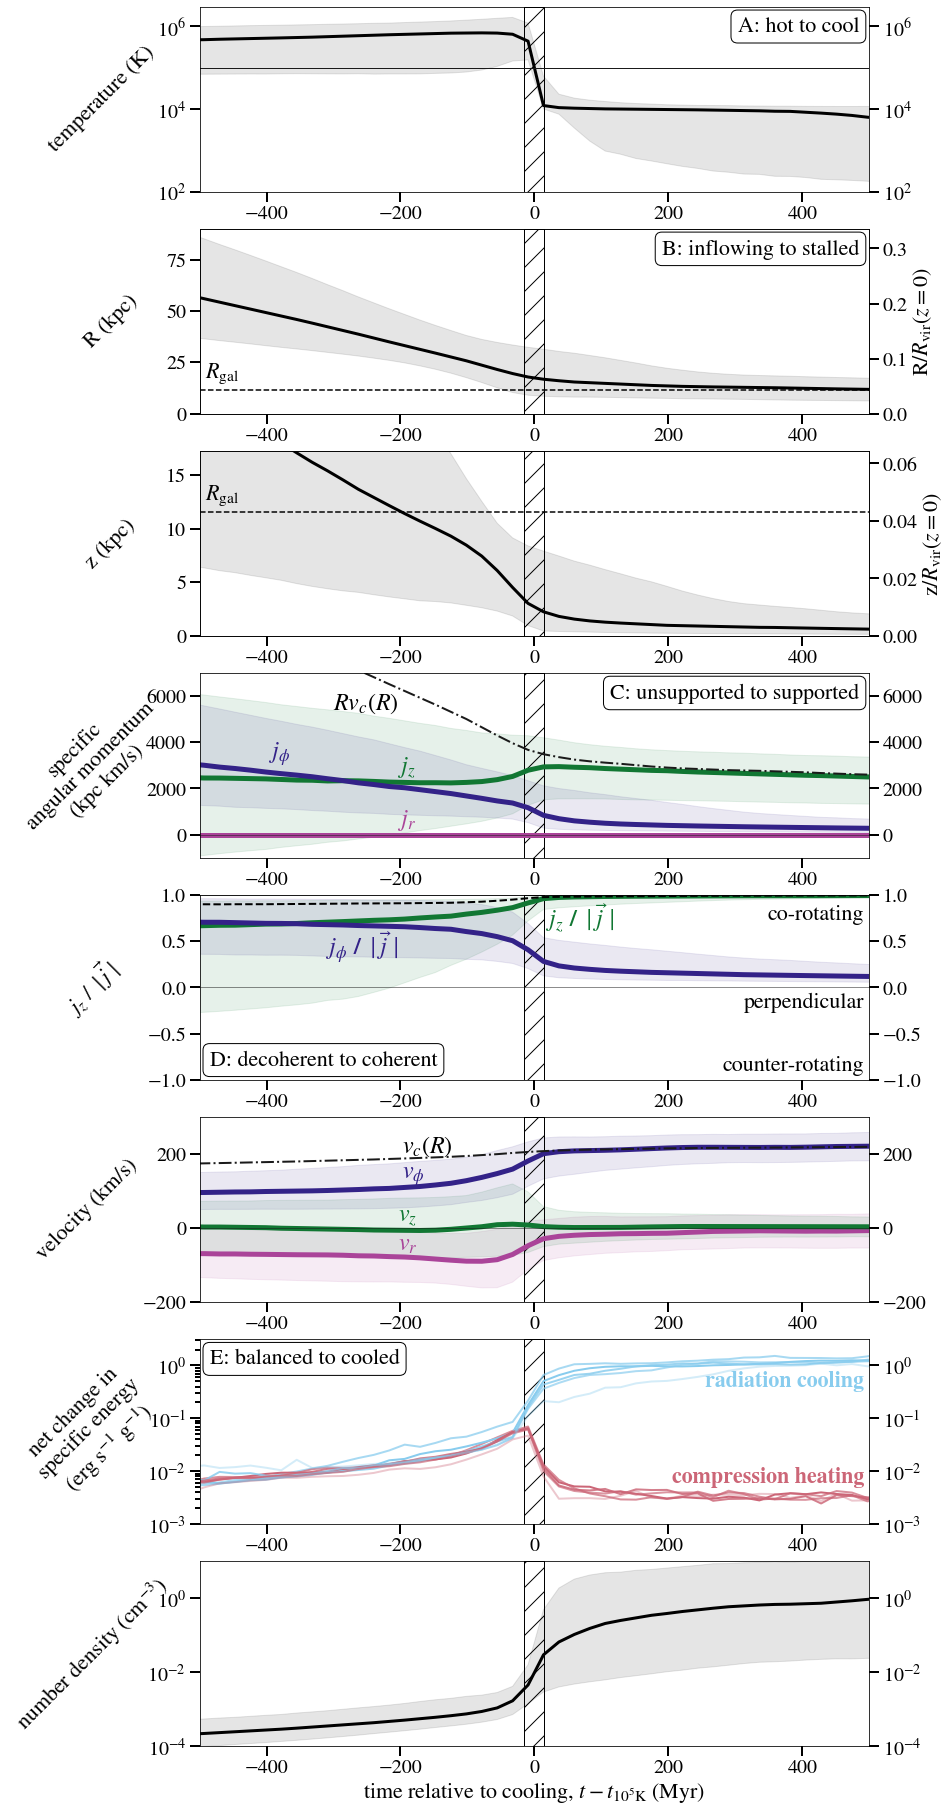

In [81]:
fig

### Paper Version

#### Setup

In [82]:
nrows = 7
fig = plt.figure( figsize=(12, 4 * nrows), facecolor='w' )
# main_ax = plt.gca()

gs = gridspec.GridSpec( ncols=1, nrows=nrows, )

errt = 30./2.

panel_letters = 'ABCDEFGHIJK'

i = 0

<Figure size 864x2016 with 0 Axes>

#### Temperature

In [83]:
ax = fig.add_subplot( gs[i,:] )

ax.annotate(
    text =r'{}: hot to cool'.format( panel_letters[i] ),
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 20,
    bbox = dict(boxstyle='round', facecolor='w')
)

# Plot T
ax.plot(
    time,
    med_gas_temp,
    color = 'k',
    linewidth = 3,
)
ax.fill_between(
    time,
    low_gas_temp,
    high_gas_temp,
    color = 'k',
    alpha = 0.1,
)

# Label lines
ax.axhline(
    1e5,
    color = '0.1',
    linewidth = 1,
)
ax.annotate(
    text =r'$T = 10^5$ K',
    xy = ( -errt, 1e5 ),
    xycoords = 'data',
    xytext = ( -5, -5 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
)

ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

ax.set_xlim( -500, 500 )
ax.set_ylim( 1e2, 3e6 )
ax.set_ylabel(
    'temperature (K)',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
ax.set_yscale( 'log' )
ax.tick_params( right=True, labelright=True, )
i += 1

#### Radius

In [84]:
ax = fig.add_subplot( gs[i,:] )

ax.annotate(
    text =r'{}: inflowing to stalled'.format( panel_letters[i] ),
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

r_med = np.nanpercentile( r, 50., axis=0 )
ax.plot(
    time,
    r_med[inds2],
    color = 'k',
    linewidth = 3,
)
ax.fill_between(
    time,
    np.nanpercentile( r, 16, axis=0 )[inds2],
    np.nanpercentile( r, 84., axis=0 )[inds2],
    color = 'k',
    alpha = 0.1,
)

# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)
# ax.axhline(
#     r_med[0],
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
# ax.annotate(
#     text =r'$R(t=t_{10^5{\rm K}})$',
#     xy = ( 0, r_med[0] ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 22,
#     ha = 'left',
#     va = 'bottom',
# )

ax.axhline(
    w.r_gal[0],
    color = '0.1',
    linewidth = 1,
)
ax.annotate(
#     text =r'$4 R_\star(z=0)$',
    text =r'$R_{\rm gal}$',
#     text ='disk radius',
    xy = ( 0, w.r_gal[0] ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 22,
    ha = 'left',
    va = 'bottom',
    color = 'k',
    fontweight = 'bold',
)

ax.set_xlim( -500, 500 )
ax.set_ylim( 0, 90 )
# ax.set_yscale( 'log' )
# ax.set_ylim( 5, 100 )
ax.set_ylabel(
    'R (kpc)',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
    
ax_r = ax.twinx()
ax_ylim = ax.get_ylim()
ax_r.set_ylim( np.array( ax_ylim ) / w.r_vir[600] )
ax_r.set_ylabel( r'R/$R_{\rm vir}(z=0)$', fontsize=22 )

# ax.tick_params( right=True, labelright=True, )
i += 1


#### Vertical Height

In [85]:
ax = fig.add_subplot( gs[i,:] )

ax.annotate(
    text =r'{}: diffuse to collapsed'.format( panel_letters[i] ),
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

z_abs = np.abs( z[:,inds2] )

ax.plot(
    time,
    np.nanmedian( z_abs, axis=0 ),
    color = 'k',
    linewidth = 3,
)
ax.fill_between(
    time,
    np.nanpercentile( z_abs, 16, axis=0 ),
    np.nanpercentile( z_abs, 84., axis=0 ),
    color = 'k',
    alpha = 0.1,
)


# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)
# ax.axhline(
#     r_med[0],
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
# ax.annotate(
#     text =r'$R(t=t_{10^5{\rm K}})$',
#     xy = ( 0, r_med[0] ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 22,
#     ha = 'left',
#     va = 'bottom',
# )

ax.axhline(
    w.r_gal[0],
    color = '0.1',
    linewidth = 1,
)
ax.annotate(
#     text =r'$4 R_\star(z=0)$',
    text =r'$R_{\rm gal}$',
#     text ='disk radius',
    xy = ( 0, w.r_gal[0] ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, -5 ),
    textcoords = 'offset points',
    fontsize = 22,
    ha = 'left',
    va = 'top',
    color = 'k',
    fontweight = 'bold',
)

ax.set_xlim( -500, 500 )
ax.set_ylim( 0, 1.1 * w.r_gal[0] )
# ax.set_yscale( 'log' )
# ax.set_ylim( 5, 100 )
ax.set_ylabel(
    r'$\mid z \mid$ (kpc)',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
    
ax_r = ax.twinx()
ax_ylim = ax.get_ylim()
ax_r.set_ylim( np.array( ax_ylim ) / w.r_vir[600] )
ax_r.set_ylabel( r'$\mid z \mid /R_{\rm vir}(z=0)$', fontsize=22 )

# ax.tick_params( right=True, labelright=True, )
i += 1

#### Angular Momentum Components

In [86]:
ax = fig.add_subplot( gs[i,:] )

ax.annotate(
    text =r'{}: unsupported to supported'.format( panel_letters[i] ),
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# Total angular momentum
j_med = np.nanpercentile( jmag, 50., axis=0 )
ax.plot(
    time,
    j_med[inds2],
    color = colormap[3],
#     color = 'k',
    linewidth = 5,
)
ax.fill_between(
    time,
    np.nanpercentile( jmag, 16, axis=0 )[inds2],
    np.nanpercentile( jmag, 84., axis=0 )[inds2],
    color = colormap[3],
#     color = 'k',
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, j_med[inds2] )( -500 )
ax.annotate(
    text =r'$\mid \vec j \mid$',
    xy = ( 0, y_annot ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[3],
#     color = 'k',
    fontweight = 'bold',
)

# z-component angular momentum
j_med = np.nanpercentile( jz, 50., axis=0 )
ax.plot(
    time,
    j_med[inds2],
    color = colormap[4],
#     color = 'k',
    linewidth = 5,
)
ax.fill_between(
    time,
    np.nanpercentile( jz, 16, axis=0 )[inds2],
    np.nanpercentile( jz, 84., axis=0 )[inds2],
    color = colormap[4],
#     color = 'k',
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, j_med[inds2] )( -500 )
ax.annotate(
    text =r'$j_z$',
    xy = ( 0, y_annot ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[4],
#     color = 'k',
    fontweight = 'bold',
)

# Rvc
rvc_med = np.nanpercentile( rvc, 50., axis=0 )
ax.plot(
    time,
    rvc_med[inds2],
#     color = colormap[4],
    color = '.1',
    linewidth = 2,
    linestyle = '--',
)
# ax.fill_between(
#     time,
#     np.nanpercentile( rvc, 16, axis=0 )[inds2],
#     np.nanpercentile( rvc, 84., axis=0 )[inds2],
#     color = colormap[4],
#     alpha = 0.1,
# )
y_annot = scipy.interpolate.interp1d( time, rvc_med[inds2] )( -200 )
ax.annotate(
    text =r'$Rv_c(R)$',
    xy = ( -200, y_annot ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -2, -2 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
#     color = colormap[4],
    color = 'k',
    fontweight = 'bold',
)

# # Alternative that's the ratio
# j_med = np.nanpercentile( jmag / rvc, 50., axis=0 )
# ax.plot(
#     time,
#     j_med[inds2],
#     color = 'k',
#     linewidth = 5,
# )
# ax.fill_between(
#     time,
#     np.nanpercentile( jmag / rvc, 16, axis=0 )[inds2],
#     np.nanpercentile( jmag / rvc, 84., axis=0 )[inds2],
#     color = 'k',
#     alpha = 0.1,
# )
# ax.axhline(
#     1.,
#     color = 'k',
#     linestyle = '--',
# )

# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

# ax.axhline(
#     j_med[0],
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
# ax.annotate(
#     text =r'$j(t=t_{10^5{\rm K}})$',
#     xy = ( -200, j_med[0] ),
# #     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xycoords = 'data',
#     xytext = ( -5, -5 ),
#     textcoords = 'offset points',
#     fontsize = 22,
#     ha = 'right',
#     va = 'top',
# )

ax.set_xlim( -500, 500 )
ax.set_ylim( 0, 8100 )
# ax.set_ylim( 0, 1. )
ax.set_ylabel(
    'specific\nangular momentum\n(kpc km/s)',
#     r'$\mid \vec j \mid / (\, Rv_c(R)\, )$',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
ax.tick_params( right=True, labelright=True, )
i += 1

#### Circularity

In [87]:
ax = fig.add_subplot( gs[i,:] )

# y_annot = scipy.interpolate.interp1d( time, np.nanpercentile( c, 84., axis=0 )[inds2] )( -100 )
ax.annotate(
    text =r'{}: decoherent to coherent'.format( panel_letters[i] ),
    xy = ( 0, 0 ),
    xycoords = 'axes fraction',
    xytext = ( 10, 10 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'left',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

c = jz / jmag
c_med = np.nanpercentile( c, 50., axis=0 )
ax.plot(
    time,
    c_med[inds2],
#     total_jz_jmag[inds2],
    color = 'k',
    linewidth = 5,
)
ax.fill_between(
    time,
    np.nanpercentile( c, 16, axis=0 )[inds2],
    np.nanpercentile( c, 84., axis=0 )[inds2],
    color = 'k',
    alpha = 0.1,
)
# y_annot = scipy.interpolate.interp1d( time, c_med[inds2] )( -500 )
# ax.annotate(
#     text =r'median',
#     xy = ( 0, y_annot ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, -5 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'left',
#     fontsize = 22,
# )

ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

# # Net jz/j in bins
# for i, jz_jmag in enumerate( mean_jz_jmag ):
#     ax.plot(
#         time,
#         jz_jmag[inds2],
#         color = 'k',
#         alpha = n_bin[i]/n_bin.max(),
#         linewidth = 2,
#         linestyle = '--',
#     )

# Net jz/j
ax.plot(
    time,
    total_jz_jmag[inds2],
    color = 'k',
    linestyle = '--',
    linewidth = 2,
)
# y_annot = scipy.interpolate.interp1d( time, total_jz_jmag[inds2] )( -500 )
# ax.annotate(
#     text =r'$L_z$ / $\mid \vec L \mid$',
#     xy = ( 0, y_annot ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, -2.5 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'left',
#     fontsize = 22,
# )

# # Circulation
# ax.plot(
#     time,
#     circulation[inds2],
#     color = 'k',
#     linestyle = '-.',
#     linewidth = 2,
# )


ax.axhline(
    1,
    color = '0.1',
    linewidth = 1,
)
ax.annotate(
    text ='co-rotating',
    xy = ( 1, 1 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
)
ax.axhline(
    0,
    color = '0.1',
    linewidth = 0.5,
)
ax.annotate(
    text ='perpendicular',
    xy = ( 1, 0 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, -5 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
)
ax.annotate(
    text ='counter-rotating',
    xy = ( 1, -1 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, 5 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'right',
    fontsize = 22,
)

ax.set_xlim( -500, 500 )
ax.set_ylim( -1, 1 )
ax.set_ylabel(
    r'$j_z$ / $\mid \vec j \mid$',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
ax.tick_params( right=True, labelright=True, )

i += 1

#### Energy

In [88]:
ax = fig.add_subplot( gs[i,:] )

ax.annotate(
    text =r'{}: balanced to cooled'.format( panel_letters[i] ),
    xy = ( 0, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'left',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

for j, rad in enumerate( mean_rad_per_unit_mass ):
    
#     # Don't look at edge cases from early on
#     if t1e5_bins[i] < 12:
#         continue
    
    ax.plot(
        time,
        rad[inds2],
        color = colormap[0],
        alpha = n_bin[j]/n_bin.max(),
        linewidth = 2,
    )
    ax.plot(
        time,
        mean_compress_per_unit_mass[j][inds2],
        color = colormap[1],
        alpha = n_bin[j]/n_bin.max(),
        linewidth = 2,
    )

# ax.plot(
#     time,
#     np.nanmean( rad_per_unit_mass, axis=0 )[inds2],
#     color = 'b',
#     linewidth = 3,
#     linestyle = '--',
# )
# ax.plot(
#     time,
#     np.nanmean( compress_per_unit_mass, axis=0 )[inds2],
#     color = 'r',
#     linewidth = 3,
#     linestyle = '--',
# )
# Total mean
# ax.plot(
#     time,
#     np.nanmean( remove_outliers( rad_per_unit_mass ), axis=0 )[inds2],
#     color = 'b',
#     linewidth = 3,
#     label = 'radiation',
# )
# ax.plot(
#     time,
#     np.nanmean( remove_outliers( compress_per_unit_mass ), axis=0 )[inds2],
#     color = 'r',
#     linewidth = 3,
#     label = 'compression',
# )

ax.annotate(
    text ='radiation cooling',
    xy = ( 1, 1. ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, -6 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    color = colormap[0],
    fontweight = 'bold',
)
ax.annotate(
    text ='compression heating',
    xy = ( 1, 4e-3 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, 5 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'right',
    fontsize = 22,
    color = colormap[1],
    fontweight = 'bold',
)

# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)
    
# ax.annotate(
#     text ='mean',
#     xy = ( 0, 1 ),
#     xytext = ( 5, -5 ),
#     xycoords = 'axes fraction',
#     textcoords = 'offset points',
#     fontsize = 22,
#     va = 'top',
#     ha = 'left',
# )

ax.set_yscale( 'log' )
ax.set_xlim( -500, 500 )
ax.set_ylim( 2e-3, 10**0.3 )
# ax.legend( prop={'size': 18}, loc='lower left', )
ax.tick_params( which='both', right=True, labelright=True, )
# Remove scientific notation
labels = ax.get_yticks()
ax.set_yticklabels( labels )
i += 1

ax.set_ylabel(
    'net change in\nspecific energy\n' + r'(${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$)',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)

Text(0, 0.5, 'net change in\nspecific energy\n(${\\rm erg}\\ {\\rm s}^{-1}\\ {\\rm g}^{-1}$)')

#### Density

In [89]:
ax = fig.add_subplot( gs[i,:] )

ax.annotate(
    text =r'{}: CGM to ISM'.format( panel_letters[i] ),
    xy = ( 0, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'left',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# ax.annotate(
#     text =r'A: hot to cool',
#     xy = ( 1, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( -10, -10 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'right',
#     fontsize = 22,
#     bbox = dict(boxstyle='round', facecolor='w')
# )

# Plot Den
ax.plot(
    time,
    med_gas_den,
    color = 'k',
    linewidth = 3,
)
ax.fill_between(
    time,
    low_gas_den,
    high_gas_den,
    color = 'k',
    alpha = 0.1,
)

# Label lines
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

ngal_baryon = 0.173
ax.axhline(
    ngal_baryon,
    color = '0.1',
    linewidth = 1,
)
ax.annotate(
    text =r'$n_{\rm gal}$',
    xy = ( -errt, ngal_baryon ),
    xycoords = 'data',
    xytext = ( -5, -5 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
)

ax.set_xlim( -500, 500 )
ax.set_ylim( 1e-4, 10 )
ax.set_ylabel(
    'n (cm$^{-3}$)',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
ax.set_yscale( 'log' )
ax.tick_params( right=True, labelright=True, )
i += 1

#### Finish up

In [90]:
ax.set_xlabel( r'time relative to cooling, $t - t_{10^5{\rm K}}\ ({\rm Myr})$', fontsize=22 )

Text(0.5, 0, 'time relative to cooling, $t - t_{10^5{\\rm K}}\\ ({\\rm Myr})$')

In [93]:
plotting.save_fig(
    out_dir =os.path.join( pm['figure_dir'], 'before_and_after' ),
    save_file = 'before_and_after_{}.pdf'.format( pm['variation'] ),
    fig = fig,
)

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/before_and_after/before_and_after_m12i_md.pdf


#### Output

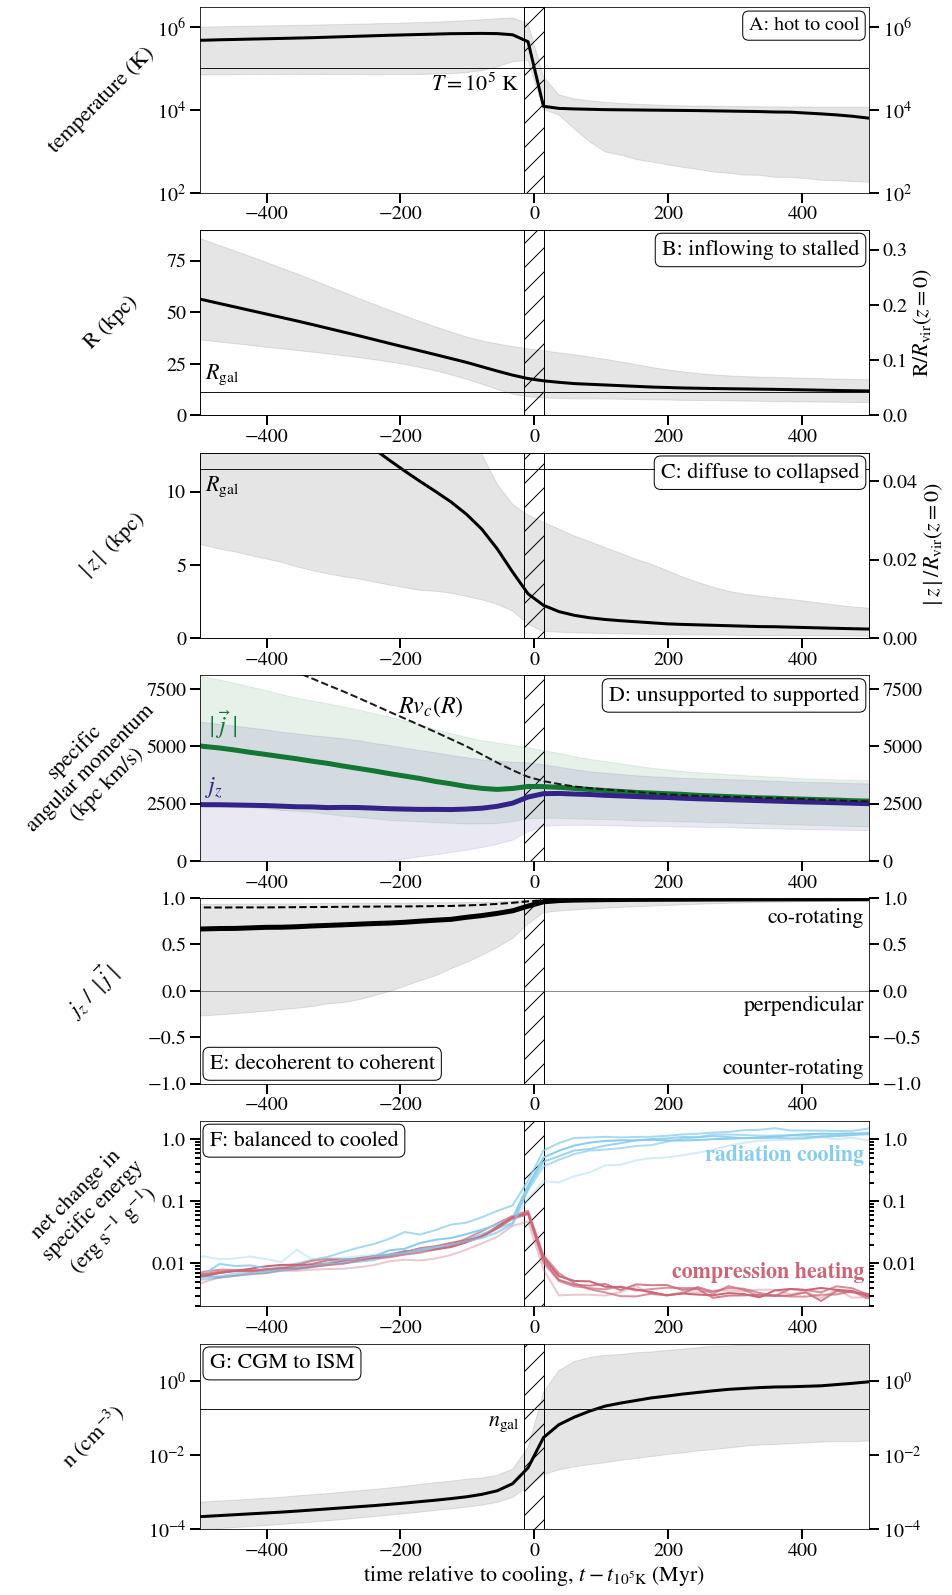

In [94]:
fig

In [95]:
# Move the time offset back
time += time_offset

### Additional Technical Plots

In [96]:
def e_per_m_hist( ax, e_per_m ):
    bins = np.logspace( -5, np.log10( np.nanmax( np.abs( e_per_m ) ) ), 32 )

    ax.hist(
        np.abs( e_per_m ),
        bins = bins,
        histtype = 'step',
        linewidth = 3,
        color = 'k',
    )
    ax.hist(
        np.abs( e_per_m[e_per_m<0] ),
        bins = bins,
        histtype = 'step',
        linewidth = 3,
        color = 'k',
        linestyle = ':',
        label = 'negative',
    )
    ax.hist(
        np.abs( e_per_m[e_per_m>0] ),
        bins = bins,
        histtype = 'step',
        linewidth = 3,
        color = 'k',
        linestyle = '--',
        label = 'positive',
    )

    ax.axvline(
        np.nanmedian( e_per_m ),
        linewidth = 3,
    )
    ax.axvline(
        np.nanmean( remove_outliers( e_per_m ) ),
        linewidth = 3,
        linestyle = '--',
    )
    ax.annotate(
        text = 'median = {:.2g}\nmean={:.2g}'.format( np.nanmedian( e_per_m ), np.nanmean( e_per_m ) ),
        xy = ( 0, 1 ),
        xytext = ( 5, -5 ),
        xycoords = 'axes fraction',
        textcoords = 'offset points',
        fontsize = 18,
        va = 'top',
        ha = 'left',
    )

    ax.set_xscale( 'log' )

    ax.legend( prop={'size': 18} )


Text(0.5, 0, 'Magnitude of Change in Radiation Specific Energy')

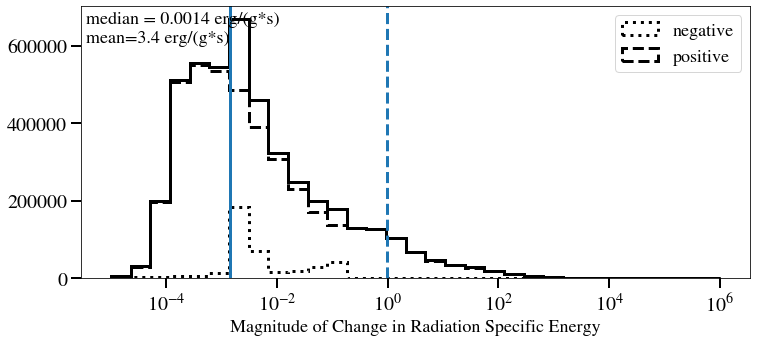

In [97]:
fig = plt.figure( figsize=(12,5), facecolor='w' )
ax = plt.gca()

e_per_m_hist( ax, rad_per_unit_mass[:,inds2].flatten(),)

ax.set_xlabel( 'Magnitude of Change in Radiation Specific Energy', fontsize=18 )

Text(0.5, 0, 'Magnitude of Change in Compression Specific Energy')

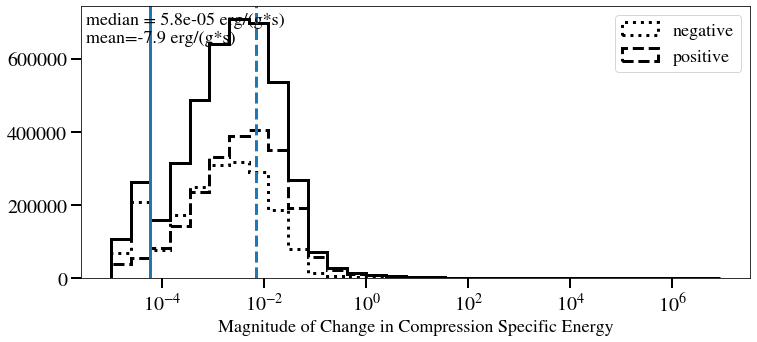

In [98]:
fig = plt.figure( figsize=(12,5), facecolor='w' )
ax = plt.gca()

e_per_m_hist( ax, compress_per_unit_mass[:,inds2].flatten(),)

ax.set_xlabel( 'Magnitude of Change in Compression Specific Energy', fontsize=18 )

# Calculate Quiet Accretion Fraction

## Calculate

In [99]:
t_cuts = [ 0., 30., 60., 90. ]
c_cuts = [ 0.95, 0.9, 0.85, 0.8, 0.75 ]
r_cuts = [ 1.5, 2, 3, 4 ]

In [100]:
c = jz / jmag
m = rolled['M'].to( 'Msun' )
quiet_frac = []
quiet_frac_strict = []
c_checks = []
r_rgal_checks = []
for i, t_cut in enumerate( tqdm.tqdm( t_cuts ) ):
    # Calculate the times to evaluate for each particle
    is_after_cooling = np.abs( rolled['t_t_1e5'].to( 'Myr' ) ) <= t_cut + 1.
    
    # Get the value and the mass at that time
    c_check = np.array([ c[i,is_after_cooling[i]].max() for i in range( is_after_cooling.shape[0] ) ])
    m_check = np.array([ m[i,is_after_cooling[i]].max() for i in range( is_after_cooling.shape[0] ) ])
    r_rgal_check = np.array([ r_rgal_rolled[i,is_after_cooling[i]].min() for i in range( is_after_cooling.shape[0] ) ])
    m_check_tot = m_check.sum()
    
    c_checks.append( c_check )
    r_rgal_checks.append( r_rgal_check )
    
    # Loop and calculate the fraction
    quiet_frac_i = []
    quiet_frac_strict_i = []
    for j, c_cut in enumerate( c_cuts ):
        sufficient_c = c_check>c_cut
        quiet_frac_i.append( m_check[sufficient_c].sum() / m_check_tot )
        
        quiet_frac_strict_j = []
        for k, r_cut in enumerate( r_cuts ):
            sufficiently_small_r = r_rgal_check < r_cut
            quiet_frac_strict_j.append( m_check[sufficient_c&sufficiently_small_r].sum() / m_check_tot )
        quiet_frac_strict_i.append( quiet_frac_strict_j )
        
    quiet_frac.append( quiet_frac_i )
    quiet_frac_strict.append( quiet_frac_strict_i )
    
quiet_frac = np.array( quiet_frac )
quiet_frac_strict = np.array( quiet_frac_strict )

100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


Saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/quiet_acc_fraction/quiet_acc_fraction_m12i_md.pdf


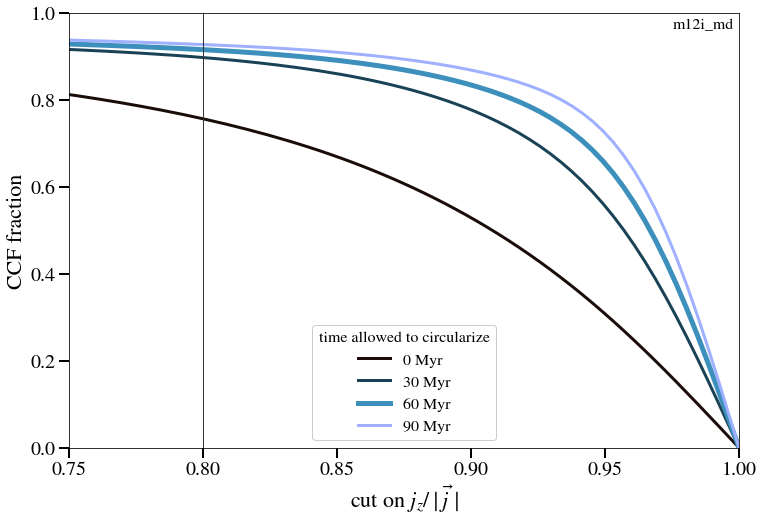

In [101]:
# Plot distributions used to classify
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

for i, t_cut in enumerate( t_cuts ):
    
    c_points, c_pdf = kale.density(
        c_checks[i][np.invert(np.isnan(c_checks[i]))],
        points = np.linspace( -1, 1, 512 ),
        probability = True,
        reflect = [ -1, 1 ],
    )
    
    c_cdf = np.cumsum( c_pdf )
    c_cdf /= c_cdf[-1]
    
    quiet_acc_frac = 1 - c_cdf
    
    ax.plot(
        c_points,
        quiet_acc_frac,
        c = palettable.scientific.diverging.Berlin_7_r.mpl_colors[3+i],
        label = '{:.3g} Myr'.format( t_cut ),
        linewidth = {
            True: 5,
            False: 3,
        }[np.isclose(t_cut, pm['t_cut'])]
    )
    
ax.axvline(
    pm['c_cut'],
    linewidth = 1,
    color = '.2',
)
    
ax.set_xlim( 0.75, 1 )
ax.set_ylim( 0, 1 )

ax.set_xlabel( r'cut on $j_z/\mid \vec j \mid$', fontsize=22 )
ax.set_ylabel( r'CCF fraction', fontsize=22 )

ax.legend(
    prop={'size': 16, },
    title = 'time allowed to circularize',
    title_fontsize = 16,
#     loc = 'lower left',
    framealpha = 1,
)

ax.annotate(
    text =pm['variation'],
    xy = ( 1, 1 ),
    xytext = ( -5, -5 ),
    xycoords = 'axes fraction',
    textcoords = 'offset points',
    fontsize = 16,
    va = 'top',
    ha = 'right',
)

save_dir = os.path.join( pm['figure_dir'], 'quiet_acc_fraction' )
os.makedirs( save_dir, exist_ok=True )
save_fp = os.path.join( save_dir, 'quiet_acc_fraction_{}.pdf'.format( pm['variation'] ) )
pl.savefig( save_fp, bbox_inches='tight' )
print( 'Saved at {}'.format( save_fp ) )

Saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/quiet_acc_fraction_strict/quiet_acc_fraction_strict_m12i_md.pdf


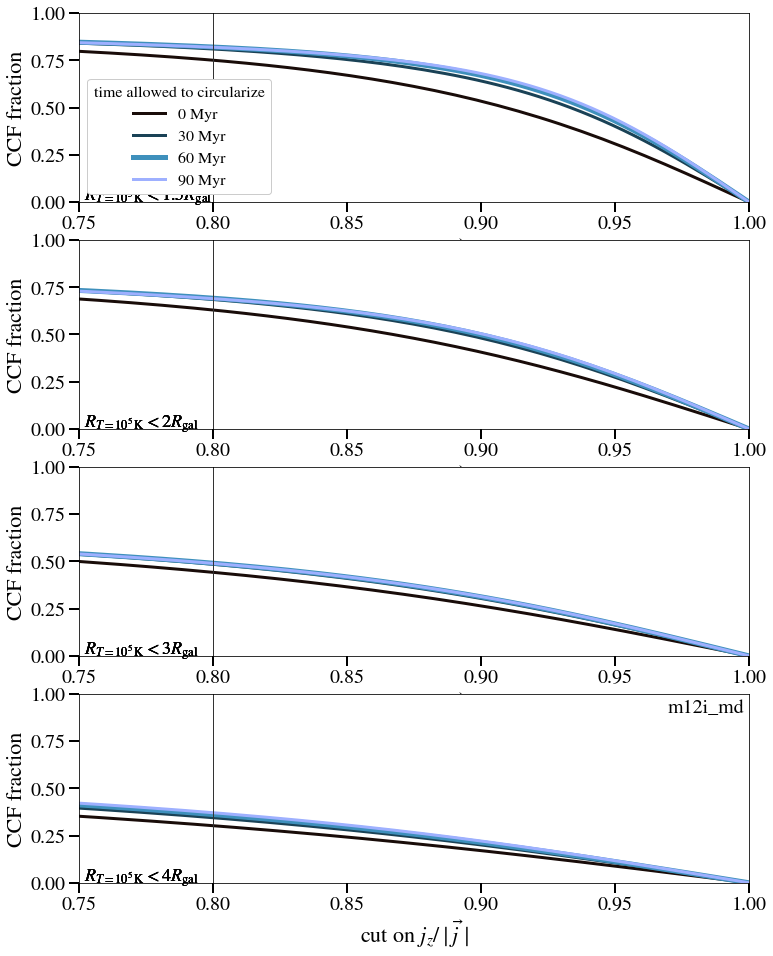

In [102]:
# Plot distributions used to classify
n_rows = len( r_cuts )

fig = plt.figure( figsize=(12,n_rows*4), facecolor='w' )
ax = plt.gca()

gs = gridspec.GridSpec( n_rows, 1 )

for k, r_cut in enumerate( r_cuts ):
    
    ax_k = plt.subplot( gs[k,0] )

    for i, t_cut in enumerate( t_cuts ):
        
        data = c_checks[i][r_rgal_checks[i]>r_cut]

        c_points, c_pdf = kale.density(
            data[np.invert(np.isnan(data))],
            points = np.linspace( -1, 1, 512 ),
            probability = True,
            reflect = [ -1, 1 ],
        )

        c_cdf = np.cumsum( c_pdf )
        c_cdf /= c_cdf[-1]

        quiet_acc_frac = 1 - c_cdf

        ax_k.plot(
            c_points,
            quiet_acc_frac,
            c = palettable.scientific.diverging.Berlin_7_r.mpl_colors[3+i],
            label = '{:.3g} Myr'.format( t_cut ),
            linewidth = {
                True: 5,
                False: 3,
            }[np.isclose(t_cut, pm['t_cut'])]
        )
        
        ax_k.annotate(
            text =r'$R_{T=10^5\,{\rm K}} < $' +'{:.3g}'.format( r_cut ) + r'$R_{\rm gal}$',
            xy = ( 0, 0 ),
            xytext = ( 5, -5 ),
            xycoords = 'axes fraction',
            textcoords = 'offset points',
            fontsize = 18,
            va = 'bottom',
            ha = 'left',
        )
        
    ax_k.axvline(
        pm['c_cut'],
        linewidth = 1,
        color = '.2',
    )

    ax_k.set_xlim( 0.75, 1 )
    ax_k.set_ylim( 0, 1 )

    ax_k.set_xlabel( r'cut on $j_z/\mid \vec j \mid$', fontsize=22 )
    ax_k.set_ylabel( r'CCF fraction', fontsize=22 )

    if ax_k.is_first_row():
        ax_k.legend(
            prop={'size': 16, },
            title = 'time allowed to circularize',
            title_fontsize = 16,
        #     loc = 'lower left',
            framealpha = 1,
        )
        
    if ax_k.is_last_row():
        ax_k.annotate(
            text =pm['variation'],
            xy = ( 1, 1 ),
            xytext = ( -5, -5 ),
            xycoords = 'axes fraction',
            textcoords = 'offset points',
            fontsize = 20,
            va = 'top',
            ha = 'right',
        )

save_dir = os.path.join( pm['figure_dir'], 'quiet_acc_fraction_strict' )
os.makedirs( save_dir, exist_ok=True )
save_fp = os.path.join( save_dir, 'quiet_acc_fraction_strict_{}.pdf'.format( pm['variation'] ) )
pl.savefig( save_fp, bbox_inches='tight' )
print( 'Saved at {}'.format( save_fp ) )

## Store

In [103]:
data_fp = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )

In [104]:
try:
    data = verdict.Dict.from_hdf5( data_fp )
except OSError:
    data = verdict.Dict({})

In [105]:
if 'quiet_acc_fraction' not in data.keys():
    data['quiet_acc_fraction'] = {}
quiet_acc_fraction_d = {
    'fraction': quiet_frac,
    'fraction_strict': quiet_frac_strict,
    't_cuts': t_cuts,
    'c_cuts': c_cuts,
    'r_cuts': r_cuts,
}
data['quiet_acc_fraction'][pm['variation']] = quiet_acc_fraction_d

In [106]:
data.to_hdf5( data_fp )

# Calculate Thin Disk Fraction for Tracked Particles

In [107]:
# Get values per particle
is_star_z0 = ( w.get_data('PType') == 4 )[:,0]
star_masses = w.get_data( 'M' )[:,0][is_star_z0]
c_star_z0 = ( jz_raw / jmag_raw.value )[:,0][is_star_z0]

In [108]:
# Fractions and masses
to_store = dict(
    tracked_mass_z0 = w.get_data( 'M' )[:,0].sum(),
    tracked_star_mass_z0 = star_masses.sum(),
    f_thin_tracked_z0 = star_masses[c_star_z0>0.8].sum() / star_masses.sum(),
)

In [109]:
for key, item in to_store.items():
    if key not in data.keys():
        data[key] = {}
    data[key][pm['variation']] = item

In [110]:
data.to_hdf5( data_fp )